Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima

Load dataset and prepare df

In [2]:
# Load the dataset
file_path = '../data/WHO-COVID-19-global-data.csv'
date_column = 'Date_reported'
target_column = 'New_deaths'
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()

Determine whether the dataset is stationary

In [3]:
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df[target_column])

1. ADF :  -2.1134171180648744
2. P-Value :  0.23915384830229824
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression: 1389
5. Critical Values :
	 1% :  -3.4350666494778137
	 5% :  -2.8636230590277587
	 10% :  -2.5678790153478865


Parameter tuning for order

In [4]:
stepwise_fit = auto_arima(df[target_column], trace=True,
suppress_warnings=True)
best_order=stepwise_fit.order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25528.870, Time=3.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26672.005, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26325.080, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25798.210, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26670.005, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25718.319, Time=2.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25803.620, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25555.335, Time=2.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25579.550, Time=2.95 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25795.797, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25556.676, Time=2.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25782.320, Time=0.41 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25397.393, Time=2.69 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=25516.997, Time=3.39 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=25441.308, Time=3.85

Plot ACF and PACF for ARIMA order identification

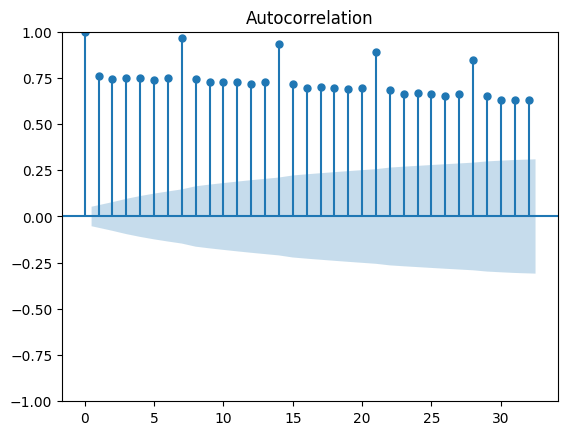

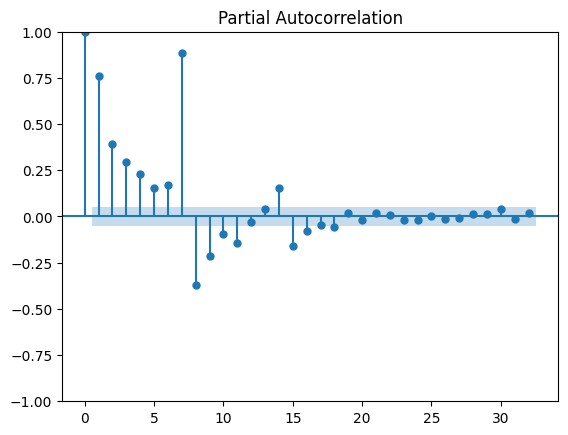

In [5]:
train = df[[target_column]].iloc[:-30]
test = df[[target_column]].iloc[-30:]
plot_acf(train)
plt.show()

plot_pacf(train)
plt.show()

Create Model

In [6]:
model=ARIMA(train[target_column],order=best_order)
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             New_deaths   No. Observations:                 1377
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -12366.430
Date:                Thu, 16 Nov 2023   AIC                          24746.861
Time:                        13:37:28   BIC                          24783.449
Sample:                             0   HQIC                         24760.550
                               - 1377                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4034      0.038    -10.698      0.000      -0.477      -0.330
ar.L2         -0.2849      0.041     -6.948      0.000      -0.365      -0.205
ma.L1         -0.5926      0.024    -24.676      0.000      -0.640      -0.545
ma.L2         -0.2288      0.027     -8.574      0.000      -0.281      -0.177
ma.L3         -0.6046      0.023    -26.857      0.000      -0.649      -0.560
ma.L4          0.7443      0.012     64.155      0.000       0.722       0.767
sigma2      3.737e+06   7.35e+04     50.824      0.000    3.59e+06    3.88e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):              4531.86
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

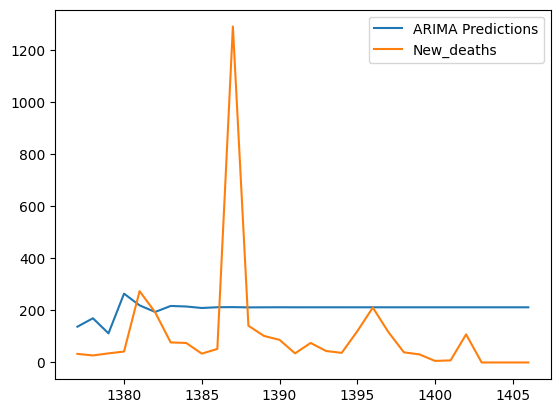

In [7]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test[target_column].plot(legend=True)

RMSE of the result

In [8]:

test[target_column].mean()
rmse=sqrt(mean_squared_error(pred,test[target_column]))
print(rmse)

247.97458071744578
